In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load Veltri dataset
veltri_train = pd.read_csv('veltri_train.csv')
veltri_val = pd.read_csv('veltri_val.csv')
veltri_test = pd.read_csv('veltri_test.csv')

# Load LMPred dataset
lmpred_train = pd.read_csv('lmpred_train.csv')
lmpred_val = pd.read_csv('lmpred_val.csv')
lmpred_test = pd.read_csv('lmpred_test.csv')

print("=== Dataset Sizes ===")
print(f"Veltri - Train: {len(veltri_train)}, Val: {len(veltri_val)}, Test: {len(veltri_test)}")
print(f"LMPred - Train: {len(lmpred_train)}, Val: {len(lmpred_val)}, Test: {len(lmpred_test)}")

=== Dataset Sizes ===
Veltri - Train: 1424, Val: 708, Test: 1424
LMPred - Train: 3005, Val: 1504, Test: 3007


In [3]:
def create_kmers(sequence, k=3):
    """
    Convert sequence to k-mers with spaces
    Example: "ABCDEF" with k=3 -> "ABC BCD CDE DEF"
    """
    return ' '.join([sequence[i:i+k] for i in range(len(sequence) - k + 1)])

def prepare_features(df, k=3):
    """Apply k-mer transformation to sequences"""
    df = df.copy()
    df['kmers'] = df['sequence'].apply(lambda x: create_kmers(x, k))
    return df

# Test k-mer creation
sample_seq = veltri_train['sequence'].iloc[0]
print(f"\n=== K-mer Example (k=3) ===")
print(f"Original: {sample_seq[:30]}...")
print(f"K-mers: {create_kmers(sample_seq, k=3)[:50]}...")

# Apply to all datasets
k = 3  # tri-peptides (standard in AMP literature)

veltri_train_kmer = prepare_features(veltri_train, k)
veltri_val_kmer = prepare_features(veltri_val, k)
veltri_test_kmer = prepare_features(veltri_test, k)

lmpred_train_kmer = prepare_features(lmpred_train, k)
lmpred_val_kmer = prepare_features(lmpred_val, k)
lmpred_test_kmer = prepare_features(lmpred_test, k)


=== K-mer Example (k=3) ===
Original: QNVMGRGIALPGMANPQMFQRASTDLEEET...
K-mers: QNV NVM VMG MGR GRG RGI GIA IAL ALP LPG PGM GMA MA...


In [4]:
def train_baseline_model(train_df, val_df, test_df, dataset_name):
    """
    Train logistic regression with k-mer features
    """
    print(f"\n{'='*60}")
    print(f"Training Baseline Model: {dataset_name}")
    print(f"{'='*60}")

    # Extract features and labels
    X_train = train_df['kmers']
    y_train = train_df['label']

    X_val = val_df['kmers']
    y_val = val_df['label']

    X_test = test_df['kmers']
    y_test = test_df['label']

    # Create pipeline
    # CountVectorizer: converts k-mers to count matrix
    # StandardScaler: normalize features
    # LogisticRegression: binary classifier
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer(
            analyzer='word',  # treat k-mers as words
            lowercase=False,  # amino acids are case-sensitive
            max_features=5000  # limit to top 5000 k-mers
        )),
        ('scaler', StandardScaler(with_mean=False)),  # with_mean=False for sparse matrices
        ('classifier', LogisticRegression(
            max_iter=1000,
            random_state=42,
            class_weight='balanced'  # handle class imbalance
        ))
    ])

    # Train
    print("\nTraining...")
    pipeline.fit(X_train, y_train)

    # Predict
    y_train_pred = pipeline.predict(X_train)
    y_train_proba = pipeline.predict_proba(X_train)[:, 1]

    y_val_pred = pipeline.predict(X_val)
    y_val_proba = pipeline.predict_proba(X_val)[:, 1]

    y_test_pred = pipeline.predict(X_test)
    y_test_proba = pipeline.predict_proba(X_test)[:, 1]

    # Evaluate
    results = {}

    for split_name, y_true, y_pred, y_proba in [
        ('Train', y_train, y_train_pred, y_train_proba),
        ('Val', y_val, y_val_pred, y_val_proba),
        ('Test', y_test, y_test_pred, y_test_proba)
    ]:
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='binary', zero_division=0)
        rec = recall_score(y_true, y_pred, average='binary', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
        auc = roc_auc_score(y_true, y_proba)

        results[split_name] = {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'auc': auc
        }

        print(f"\n{split_name} Results:")
        print(f"  Accuracy:  {acc:.4f}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall:    {rec:.4f}")
        print(f"  F1-score:  {f1:.4f}")
        print(f"  AUC:       {auc:.4f}")

    # Confusion matrix for test set
    cm = confusion_matrix(y_test, y_test_pred)
    print(f"\nTest Confusion Matrix:")
    print(cm)

    # Calculate specificity and sensitivity from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print(f"\nTest Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Test Specificity:          {specificity:.4f}")

    return pipeline, results

# Train on both datasets
veltri_model, veltri_results = train_baseline_model(
    veltri_train_kmer,
    veltri_val_kmer,
    veltri_test_kmer,
    "Veltri Dataset"
)

lmpred_model, lmpred_results = train_baseline_model(
    lmpred_train_kmer,
    lmpred_val_kmer,
    lmpred_test_kmer,
    "LMPred Dataset"
)


Training Baseline Model: Veltri Dataset

Training...

Train Results:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-score:  1.0000
  AUC:       1.0000

Val Results:
  Accuracy:  0.8107
  Precision: 0.7989
  Recall:    0.8305
  F1-score:  0.8144
  AUC:       0.8915

Test Results:
  Accuracy:  0.8279
  Precision: 0.8221
  Recall:    0.8371
  F1-score:  0.8295
  AUC:       0.9068

Test Confusion Matrix:
[[583 129]
 [116 596]]

Test Sensitivity (Recall): 0.8371
Test Specificity:          0.8188

Training Baseline Model: LMPred Dataset

Training...

Train Results:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-score:  1.0000
  AUC:       1.0000

Val Results:
  Accuracy:  0.7733
  Precision: 0.7591
  Recall:    0.8005
  F1-score:  0.7793
  AUC:       0.8431

Test Results:
  Accuracy:  0.7499
  Precision: 0.7415
  Recall:    0.7671
  F1-score:  0.7541
  AUC:       0.8148

Test Confusion Matrix:
[[1102  402]
 [ 350 1153]]

Test Sensitivity (Recall): 0.7671


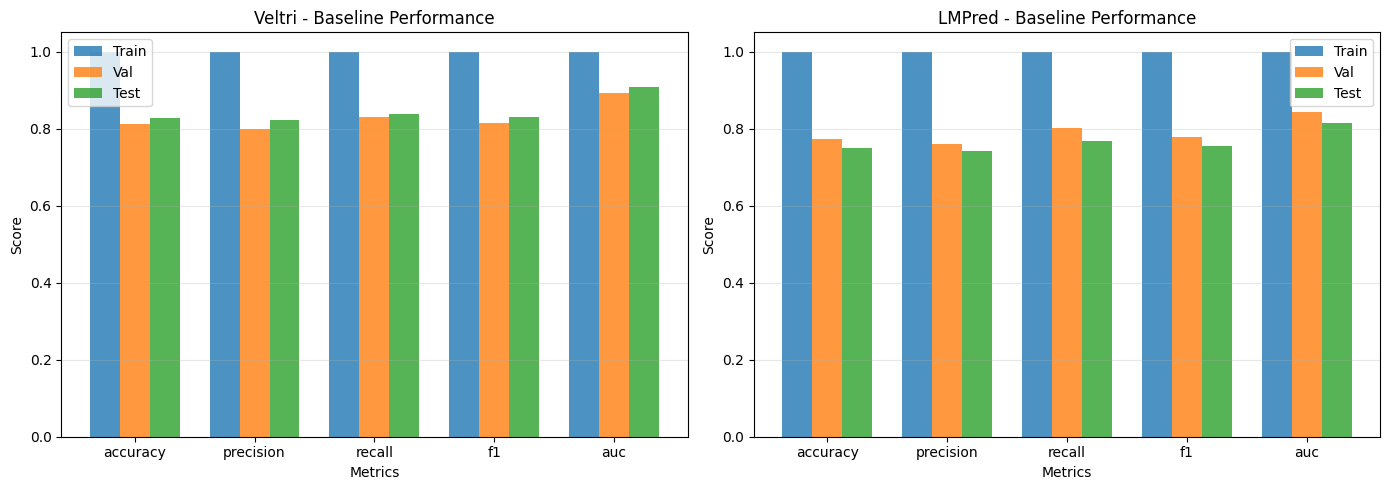

In [5]:
# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

datasets = ['Veltri', 'LMPred']
results_list = [veltri_results, lmpred_results]

for idx, (dataset_name, results) in enumerate(zip(datasets, results_list)):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    splits = ['Train', 'Val', 'Test']

    # Prepare data for plotting
    data = []
    for split in splits:
        for metric in metrics:
            data.append({
                'Split': split,
                'Metric': metric,
                'Score': results[split][metric]
            })

    df_plot = pd.DataFrame(data)

    # Grouped bar plot
    x = np.arange(len(metrics))
    width = 0.25

    for i, split in enumerate(splits):
        split_data = df_plot[df_plot['Split'] == split]
        scores = [split_data[split_data['Metric'] == m]['Score'].values[0] for m in metrics]
        axes[idx].bar(x + i*width, scores, width, label=split, alpha=0.8)

    axes[idx].set_xlabel('Metrics')
    axes[idx].set_ylabel('Score')
    axes[idx].set_title(f'{dataset_name} - Baseline Performance')
    axes[idx].set_xticks(x + width)
    axes[idx].set_xticklabels(metrics)
    axes[idx].legend()
    axes[idx].set_ylim([0, 1.05])
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# Save results to CSV for later comparison with transformers
results_df = pd.DataFrame({
    'Model': ['Baseline-LR (k=3)'] * 2,
    'Dataset': ['Veltri', 'LMPred'],
    'Test_Accuracy': [
        veltri_results['Test']['accuracy'],
        lmpred_results['Test']['accuracy']
    ],
    'Test_Precision': [
        veltri_results['Test']['precision'],
        lmpred_results['Test']['precision']
    ],
    'Test_Recall': [
        veltri_results['Test']['recall'],
        lmpred_results['Test']['recall']
    ],
    'Test_F1': [
        veltri_results['Test']['f1'],
        lmpred_results['Test']['f1']
    ],
    'Test_AUC': [
        veltri_results['Test']['auc'],
        lmpred_results['Test']['auc']
    ]
})

results_df.to_csv('baseline_results.csv', index=False)
print("\n=== Baseline Results Saved ===")
print(results_df)


=== Baseline Results Saved ===
               Model Dataset  Test_Accuracy  Test_Precision  Test_Recall  \
0  Baseline-LR (k=3)  Veltri       0.827949        0.822069     0.837079   
1  Baseline-LR (k=3)  LMPred       0.749917        0.741479     0.767132   

    Test_F1  Test_AUC  
0  0.829506  0.906779  
1  0.754088  0.814845  
